# Notebook with exploratioin on the exercise from Max de Goede
This is the second version of my Visual explanation lesson, this version drops the final asym later

## Imports

In [69]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from keras.initializers import glorot_uniform

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm

## 1) Load model and weights

In [70]:
# Loading model
with open('model.json', 'r') as json_file:
    json_savedModel= json_file.read()
model= tf.keras.models.model_from_json(json_savedModel)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 384, 384, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 384, 384, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 192, 192, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [71]:
model.layers[-1].output

<tf.Tensor 'out_asymm/BiasAdd_4:0' shape=(None, 1) dtype=float32>

In [72]:
# Loading weights
model.load_weights('model_not_frozen1970annototation_type.border.h5')
# Remove the last layer (out_asym)
model._layers.pop(-1)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 384, 384, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 384, 384, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 192, 192, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

## 2) Last convolutional layer named: block5_conv3

## 3) Predicting on image

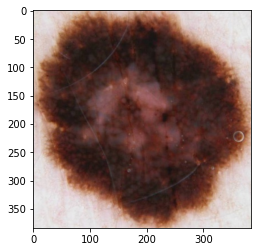

In [48]:
#Printing image 
img2 = mpimg.imread('ISIC_0000029.jpg')
imgplot = plt.imshow(img2)

In [49]:
# Reshaping image
img2.shape
img3 = np.expand_dims(img2, axis=0)
img3.shape

(1, 384, 384, 3)

In [67]:
model.predict(img3)

[array([[1.]], dtype=float32), array([[8.264874]], dtype=float32)]

In [50]:
pred = np.argmax(model.predict(img3))
print('Prediction: '+ str(pred))

Prediction: 1


## 4) Class activation heatmap on final layer

In [88]:
model_builder = keras.applications.xception.Xception

preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block5_conv3"

classifier_layer_names = [
    "flatten_1",
    #"dense_1",
    #"out_class",
]

In [89]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

Output of just the flatten_1 layer


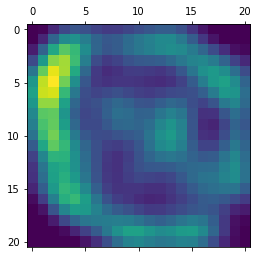

In [91]:
img_size = (350,350 )
img_array = preprocess_input(get_img_array('ISIC_0000029.jpg', size=img_size))

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
print('Output of just the flatten_1 layer')
plt.show()

## 5) Plot images

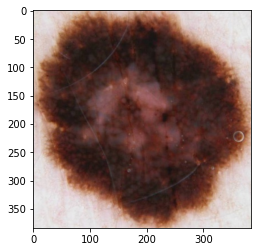

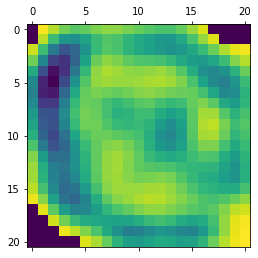

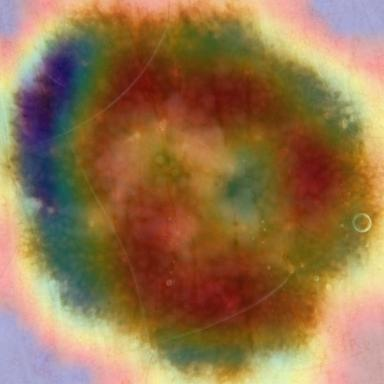

In [66]:
# We load the original image
img = keras.preprocessing.image.load_img('ISIC_0000029.jpg')
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

# Display all iamges
plt.imshow(img2)
plt.matshow(heatmap)
plt.show()
display(Image(save_path))

## 6) Conclusions
The visual helps in gaining insights on how the final layer, sees what it sees. We see that top left on the image there is a lot of pressence on the heatmap.
<br>
<br>
If i look at the image with my bare eyes i cant see anything special in the image. Adding the heatmap as an overlay, it helps bring focus to the image and highlight certain aereas of the image.